In [1]:
# This use the EIA APIto get real time electricity prices for a given state
# Can be easily automated to run automatically as a sub process
# Can only get monthly! Need to find daily somewhere, however process will be the same
# https://api.electricitymap.org/ these guys provide live hourly data -> costs £500/month
# https://www.eia.gov/opendata/qb.php

In [9]:
import eia
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    api: API that we're connected to
    series_ID: string. Name of the series that we want to pull from the EIA API
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    df = pd.DataFrame(series_search)
    return df
    

In [11]:

#Create EIA API using your specific API key
api_key = "716c2a14953da546decd4f96c16aba8d"
api = eia.API(api_key)
    
#Pull the electricity price data
series_ID='ELEC.PRICE.TX-ALL.M'
electricity_df=retrieve_time_series(api, series_ID)
electricity_df.reset_index(level=0, inplace=True)
#Rename the columns for easer analysis
electricity_df.rename(columns={'index':'Date',
            electricity_df.columns[1]:'Electricity_Price'}, 
            inplace=True)

In [12]:
#Convert the Date column into a date object
electricity_df['Date']=pd.to_datetime(electricity_df['Date'])

In [13]:
#Set Date as a Pandas DatetimeIndex
electricity_df.index=pd.DatetimeIndex(electricity_df['Date'])

In [14]:
electricity_df.drop('Date', axis = 1, inplace = True)

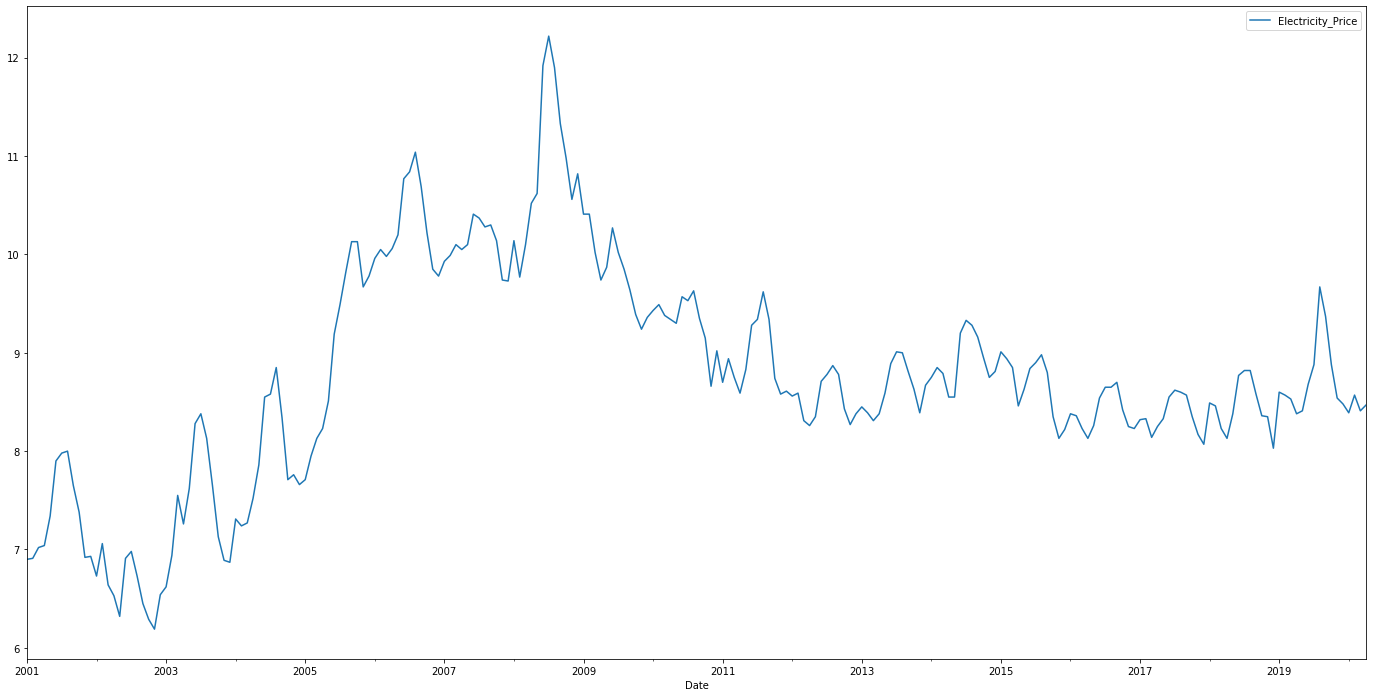

In [15]:
electricity_df.plot(figsize=(24,12))

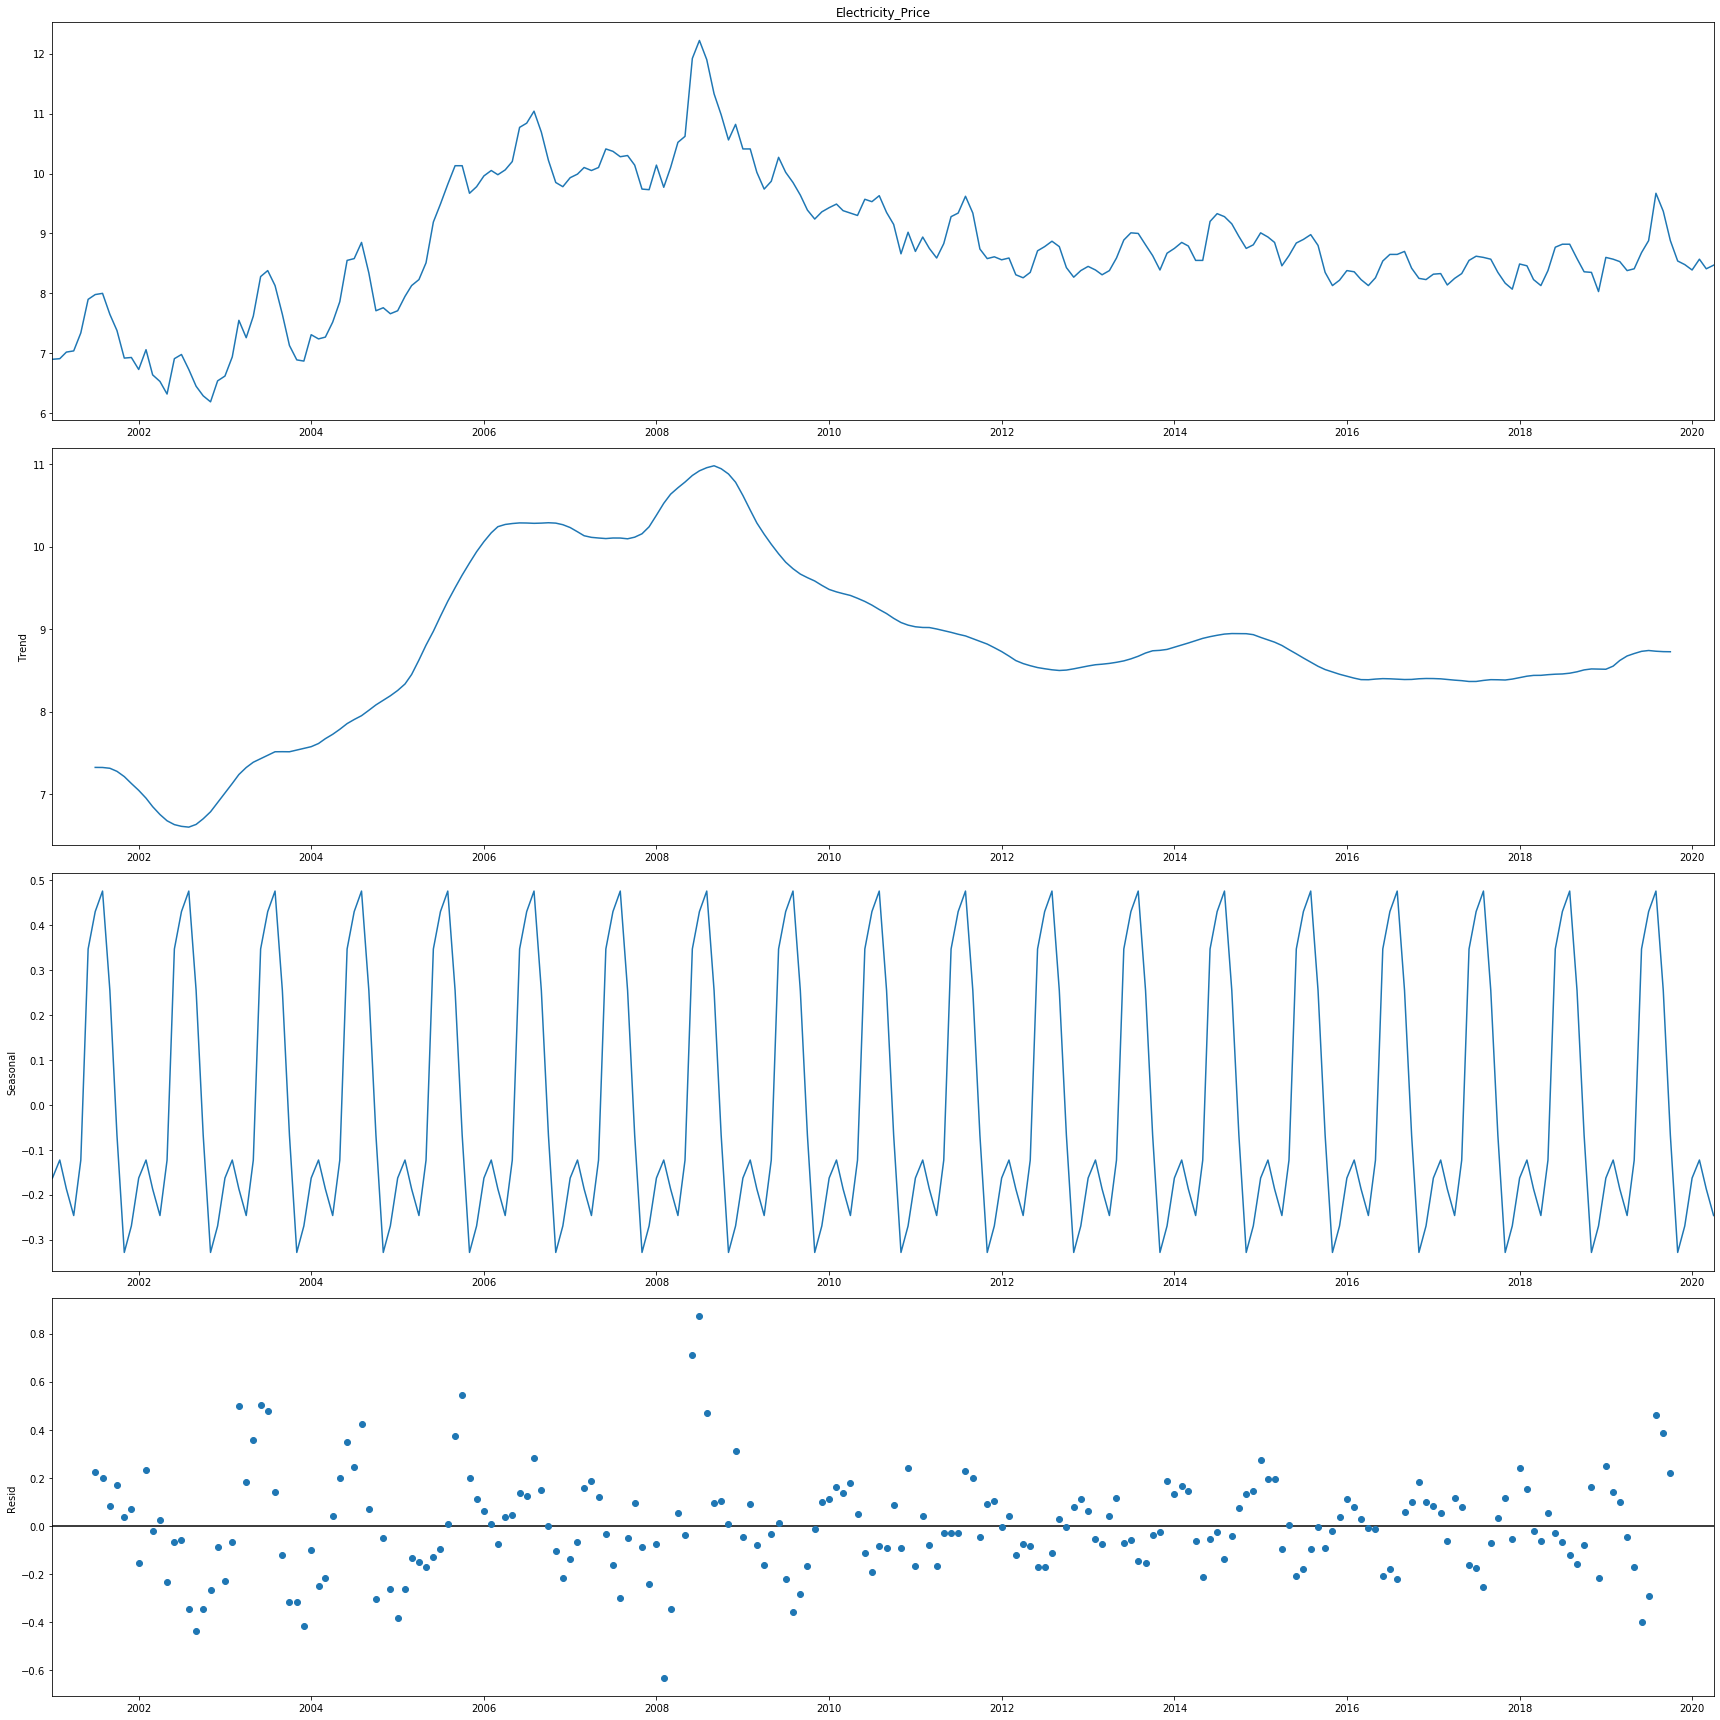

In [16]:
#Performing seasonal decomposition

from pylab import rcParams
rcParams['figure.figsize'] = 24,24
result = seasonal_decompose(electricity_df['Electricity_Price'], model='additive')
fig = result.plot()
plt.show()

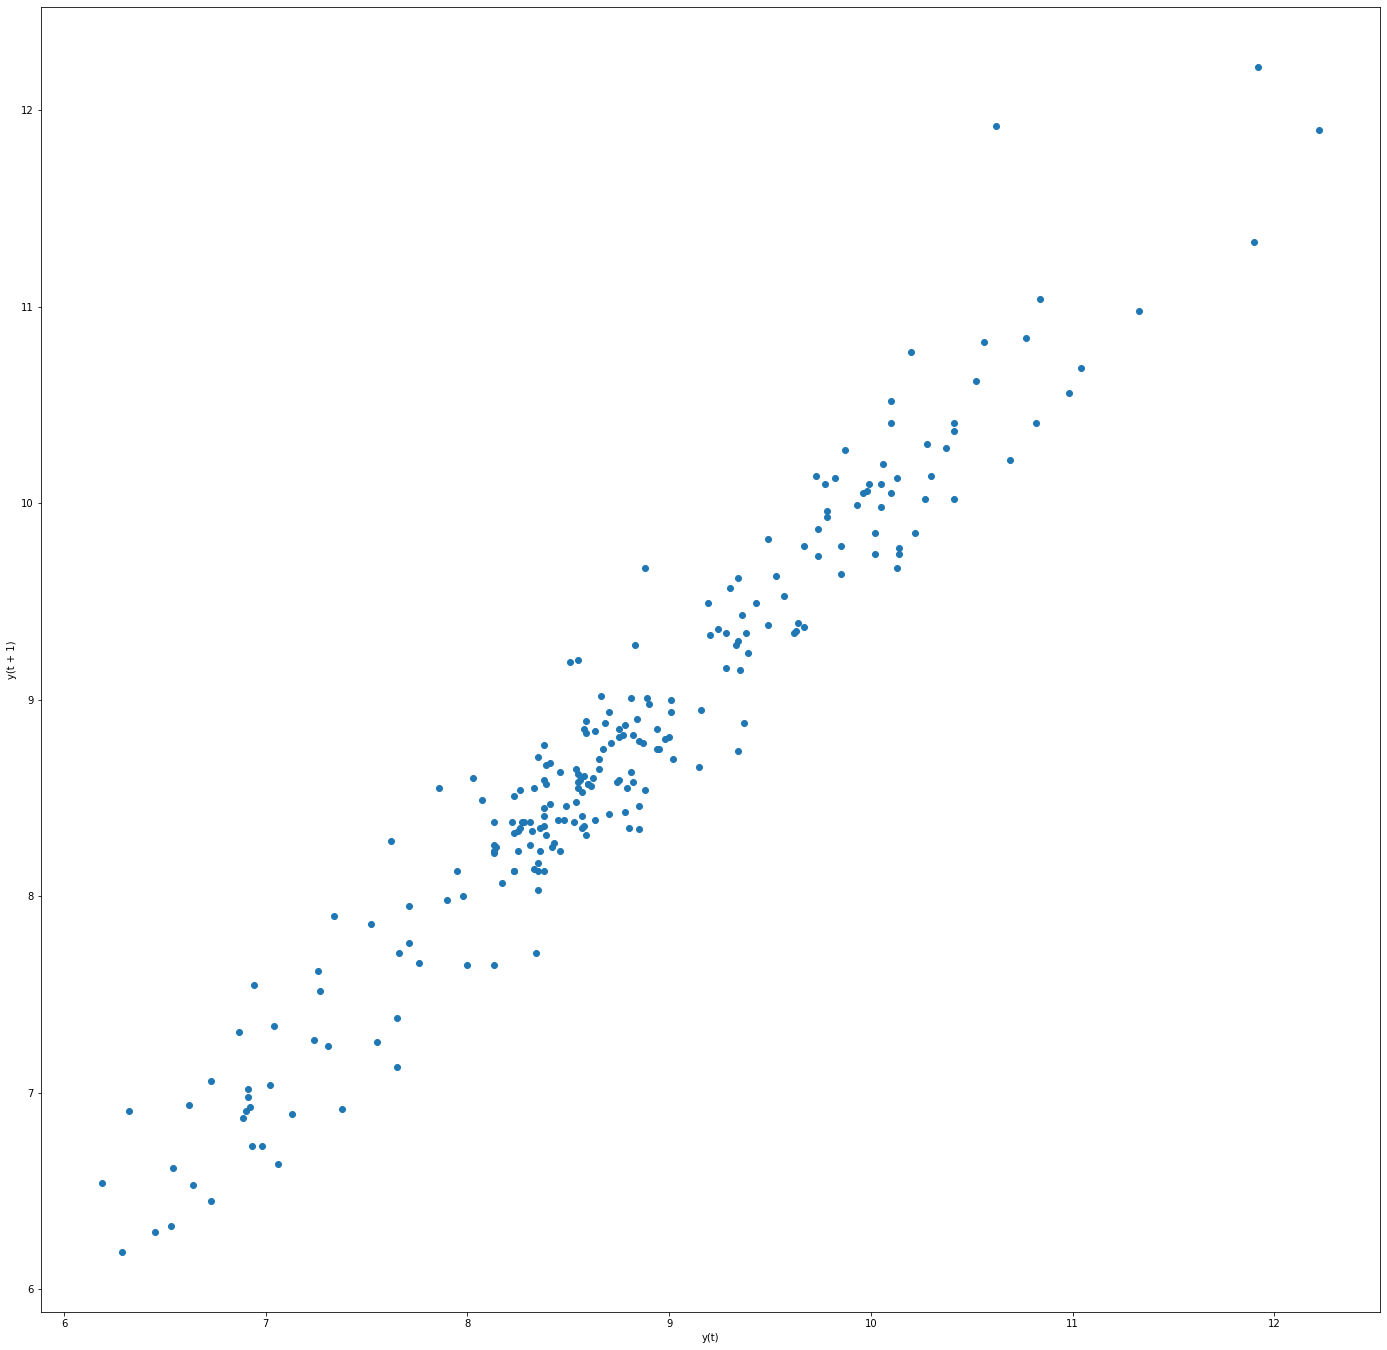

In [17]:
#Autocorrelation plot
from pandas.plotting import lag_plot

lag_plot(electricity_df['Electricity_Price']);

In [ ]:
# Good autocorrelation

In [21]:
# Set one year for testing
train = electricity_df.iloc[:219]
test = electricity_df.iloc[219:]

In [22]:
# Scaling

from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()

In [24]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [25]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [26]:
# Getting timeseries generator
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [27]:
scaled_train

array([[0.11774461],
       [0.11940299],
       [0.13764511],
       [0.14096186],
       [0.1907131 ],
       [0.28358209],
       [0.29684909],
       [0.30016584],
       [0.24212272],
       [0.1973466 ],
       [0.12106136],
       [0.12271973],
       [0.08955224],
       [0.14427861],
       [0.07462687],
       [0.05638474],
       [0.02155887],
       [0.11940299],
       [0.13101161],
       [0.08955224],
       [0.04311774],
       [0.01658375],
       [0.        ],
       [0.05804312],
       [0.07131012],
       [0.12437811],
       [0.22553897],
       [0.1774461 ],
       [0.2371476 ],
       [0.34660033],
       [0.36318408],
       [0.32172471],
       [0.24212272],
       [0.15588723],
       [0.11608624],
       [0.11276949],
       [0.18573798],
       [0.17412935],
       [0.17910448],
       [0.22056385],
       [0.27694859],
       [0.39137645],
       [0.39635158],
       [0.44112769],
       [0.35655058],
       [0.25207297],
       [0.26036484],
       [0.243

In [28]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [29]:
# What does the first batch look like?
X,y = generator[0]

In [30]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.11774461 0.11940299]
Predict this y: 
 [[0.13764511]]


In [157]:
# Redefine to get 36! months back and then predict the next month out
n_input = 36
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [158]:
# What does the first batch look like?
X,y = generator[0]

In [159]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.11774461 0.11940299 0.13764511 0.14096186 0.1907131  0.28358209
 0.29684909 0.30016584 0.24212272 0.1973466  0.12106136 0.12271973
 0.08955224 0.14427861 0.07462687 0.05638474 0.02155887 0.11940299
 0.13101161 0.08955224 0.04311774 0.01658375 0.         0.05804312
 0.07131012 0.12437811 0.22553897 0.1774461  0.2371476  0.34660033
 0.36318408 0.32172471 0.24212272 0.15588723 0.11608624 0.11276949]
Predict this y: 
 [[0.18573798]]


In [160]:
# Generating the model - LSTM RNN

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [161]:
# define model
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss="mean_squared_logarithmic_error")

In [162]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 300)               362400    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


In [163]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
183/183 [==============================] - 7s 39ms/step - loss: 0.0094
Epoch 2/50
183/183 [==============================] - 6s 35ms/step - loss: 0.0032
Epoch 3/50
183/183 [==============================] - 6s 32ms/step - loss: 0.0032
Epoch 4/50
183/183 [==============================] - 6s 33ms/step - loss: 0.0027
Epoch 5/50
183/183 [==============================] - 6s 32ms/step - loss: 0.0024
Epoch 6/50
183/183 [==============================] - 6s 33ms/step - loss: 0.0023
Epoch 7/50
183/183 [==============================] - 6s 34ms/step - loss: 0.0021
Epoch 8/50
183/183 [==============================] - 8s 43ms/step - loss: 0.0020
Epoch 9/50
183/183 [==============================] - 6s 33ms/step - loss: 0.0018
Epoch 10/50
183/183 [==============================] - 5s 29ms/step - loss: 0.0017
Epoch 11/50
183/183 [==============================] - 5s 30ms/step - loss: 0.0018
Epoch 12/50
183/183 [==============================] - 6s 32ms/step - loss: 0.0015
Epoch 13/50
1

In [164]:
model.history.history.keys()

dict_keys(['loss'])

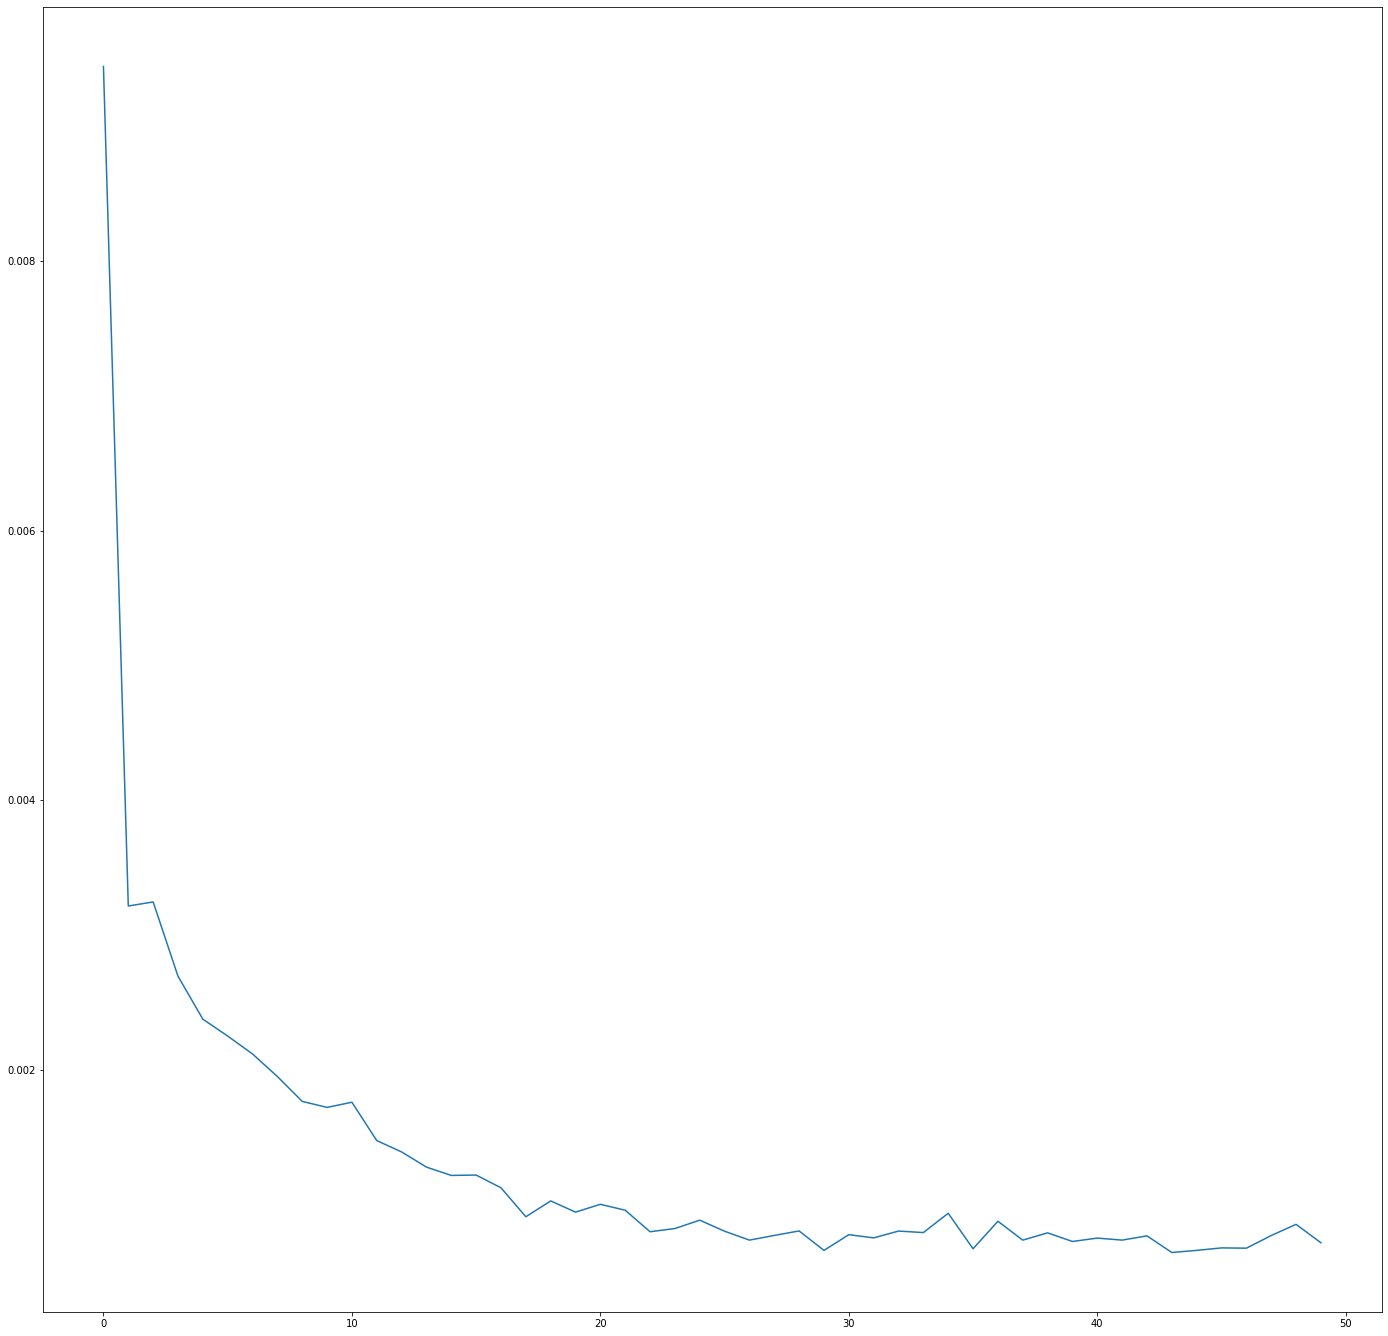

In [165]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [170]:
# Evaluating on test data

first_eval_batch = scaled_train[-36:]

In [171]:
first_eval_batch

array([[0.32172471],
       [0.34328358],
       [0.38971808],
       [0.4079602 ],
       [0.4079602 ],
       [0.41625207],
       [0.36981758],
       [0.34162521],
       [0.33830846],
       [0.35323383],
       [0.35489221],
       [0.32338308],
       [0.34162521],
       [0.35489221],
       [0.39137645],
       [0.40298507],
       [0.39966833],
       [0.3946932 ],
       [0.35820896],
       [0.32835821],
       [0.31177446],
       [0.3814262 ],
       [0.37645108],
       [0.33830846],
       [0.32172471],
       [0.36318408],
       [0.4278607 ],
       [0.43615257],
       [0.43615257],
       [0.39635158],
       [0.35986733],
       [0.35820896],
       [0.30514096],
       [0.39966833],
       [0.3946932 ],
       [0.3880597 ]])

In [172]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [173]:
model.predict(first_eval_batch)

array([[0.39345014]], dtype=float32)

In [174]:
scaled_test[0]

array([0.36318408])

In [175]:
model.predict(first_eval_batch)

array([[0.39345014]], dtype=float32)

In [176]:
scaled_test[0]

array([0.36318408])

In [177]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [178]:
test_predictions

[array([0.39345014], dtype=float32),
 array([0.40319303], dtype=float32),
 array([0.41280106], dtype=float32),
 array([0.41472277], dtype=float32),
 array([0.40589616], dtype=float32),
 array([0.39081407], dtype=float32),
 array([0.38146877], dtype=float32),
 array([0.3755836], dtype=float32),
 array([0.37203225], dtype=float32),
 array([0.37005228], dtype=float32),
 array([0.3692631], dtype=float32),
 array([0.37030375], dtype=float32),
 array([0.3790401], dtype=float32)]

In [179]:
scaled_test

array([[0.36318408],
       [0.3681592 ],
       [0.41293532],
       [0.44610282],
       [0.57711443],
       [0.52736318],
       [0.44610282],
       [0.38971808],
       [0.37976783],
       [0.36484245],
       [0.3946932 ],
       [0.3681592 ],
       [0.37810945]])

In [180]:
# Looks pretty good so far!

In [181]:
# Perform inverse tranformations for better comparison

true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[8.56250435],
       [8.62125395],
       [8.67919037],
       [8.69077831],
       [8.63755383],
       [8.54660882],
       [8.4902567 ],
       [8.45476904],
       [8.4333545 ],
       [8.42141524],
       [8.41665657],
       [8.42293161],
       [8.47561176]])

In [182]:
test

,Electricity_Price,Predictions
Date,,
2019-04-01,8.38,8.532773
2019-05-01,8.41,8.542849
2019-06-01,8.68,8.583550
2019-07-01,8.88,8.633414
2019-08-01,9.67,8.679456
2019-09-01,9.37,8.703366
2019-10-01,8.88,8.703875
2019-11-01,8.54,8.696928
2019-12-01,8.48,8.687416


In [183]:
test['Predictions'] = true_predictions

/Users/kieranodonnell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [184]:
test

,Electricity_Price,Predictions
Date,,
2019-04-01,8.38,8.562504
2019-05-01,8.41,8.621254
2019-06-01,8.68,8.679190
2019-07-01,8.88,8.690778
2019-08-01,9.67,8.637554
2019-09-01,9.37,8.546609
2019-10-01,8.88,8.490257
2019-11-01,8.54,8.454769
2019-12-01,8.48,8.433354


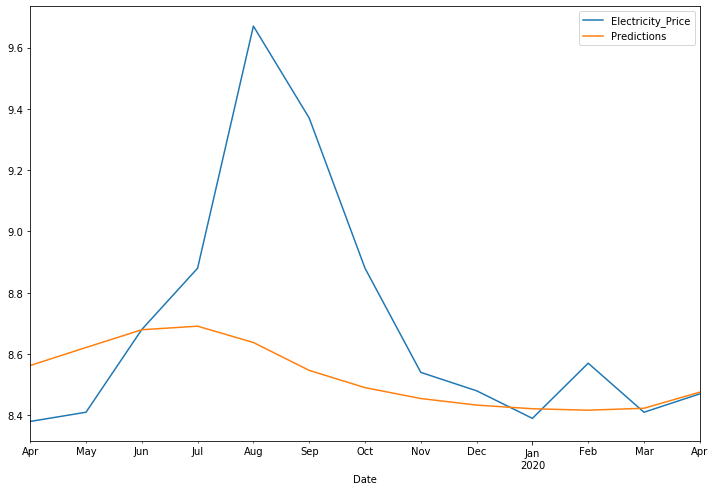

In [185]:
test.plot(figsize=(12,8))

In [186]:
# So in this case, ARIMA is way better

In [187]:
# Evaluation

from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Electricity_Price'], test['Predictions'])
print(f'RNN MSE Error: {error:11.10}')

RNN MSE Error: 0.1572076551


In [188]:
# SARIMA had MSE error of 0.07

In [189]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Electricity_Price'], test['Predictions'])
print(f'RNN RMSE Error: {error:11.10}')

RNN RMSE Error: 0.3964942057


In [190]:
# SARIMA had RMSE error of 0.26

In [191]:
test['Electricity_Price'].mean()

8.702307692307691